# BERT-GT for BioRED Relation Extraction

This notebook implements **BERT-GT (BERT with Graph Transformer)** - the official model from the BioRED paper.

## What is BERT-GT?

BERT-GT improves relation extraction by:
- **Graph Transformer layers** that model entity interactions
- **Document-level reasoning** for cross-sentence relations
- **Entity-aware attention** focusing on entity pairs

**Reference**: https://github.com/ncbi/bert_gt

## 1. Installation and Imports

In [1]:
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124


In [2]:
# Install required packages (run once)
!pip install transformers torch scikit-learn tqdm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!nvidia-smi

Fri Nov 28 14:25:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           On  |   00000000:04:00.0 Off |                    0 |
| N/A   31C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version in PyTorch: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version in PyTorch: 12.4


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from typing import List, Dict, Tuple, Optional
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, classification_report
import json
import warnings
warnings.filterwarnings('ignore')

import os
from collections import Counter, defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")
print(f"GPU index in use: {torch.cuda.current_device()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
Number of GPUs available: 3
GPU index in use: 0
GPU: Tesla P100-PCIE-16GB


## 2. Graph Transformer Layer

In [6]:
class GraphTransformerLayer(nn.Module):
    """
    Graph Transformer Layer for modeling entity interactions.
    
    This layer treats entities as nodes in a graph and uses
    graph attention to model their relationships.
    """
    
    def __init__(self, hidden_size, num_heads=4, dropout=0.1):
        super(GraphTransformerLayer, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # Multi-head attention for graph
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.out_proj = nn.Linear(hidden_size, hidden_size)
        
        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 4, hidden_size),
            nn.Dropout(dropout)
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, entity_reprs, adjacency_matrix=None):
        """
        Apply graph transformer layer.
        
        Args:
            entity_reprs: [batch_size, num_entities, hidden_size]
            adjacency_matrix: [batch_size, num_entities, num_entities] (optional)
        
        Returns:
            Updated entity representations [batch_size, num_entities, hidden_size]
        """
        batch_size, num_entities, hidden_size = entity_reprs.size()
        
        # Multi-head self-attention on graph
        Q = self.query(entity_reprs).view(batch_size, num_entities, self.num_heads, self.head_dim)
        K = self.key(entity_reprs).view(batch_size, num_entities, self.num_heads, self.head_dim)
        V = self.value(entity_reprs).view(batch_size, num_entities, self.num_heads, self.head_dim)
        
        Q = Q.transpose(1, 2)  # [batch_size, num_heads, num_entities, head_dim]
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        # Compute attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        
        # Apply adjacency matrix if provided (mask non-neighbors)
        if adjacency_matrix is not None:
            adjacency_matrix = adjacency_matrix.unsqueeze(1)  # [batch_size, 1, num_entities, num_entities]
            attention_scores = attention_scores.masked_fill(adjacency_matrix == 0, -1e9)
        
        # Attention weights
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        
        # Apply attention to values
        context = torch.matmul(attention_probs, V)  # [batch_size, num_heads, num_entities, head_dim]
        context = context.transpose(1, 2).contiguous().view(batch_size, num_entities, hidden_size)
        
        # Output projection + residual
        output = self.out_proj(context)
        output = self.dropout(output)
        entity_reprs = self.layer_norm1(entity_reprs + output)
        
        # Feed-forward + residual
        ffn_output = self.ffn(entity_reprs)
        entity_reprs = self.layer_norm2(entity_reprs + ffn_output)
        
        return entity_reprs

print("✓ GraphTransformerLayer defined")

✓ GraphTransformerLayer defined


## 3. BERT-GT Model

In [7]:
class BERTGTModel(nn.Module):
    """
    Complete BERT-GT model for document-level relation extraction.
    """
    
    def __init__(
        self,
        model_name='dmis-lab/biobert-v1.1',
        num_relations=4,
        num_graph_layers=2,
        num_attention_heads=4,
        max_entities=20,
        dropout=0.1
    ):
        super(BERTGTModel, self).__init__()
        
        # BioBERT encoder
        self.bert = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.bert.config.hidden_size
        self.max_entities = max_entities
        
        # Entity representation layer
        self.entity_projection = nn.Linear(self.hidden_size, self.hidden_size)
        
        # Graph Transformer layers
        self.graph_layers = nn.ModuleList([
            GraphTransformerLayer(
                self.hidden_size,
                num_heads=num_attention_heads,
                dropout=dropout
            )
            for _ in range(num_graph_layers)
        ])
        
        # Entity pair combination: [e1, e2, e1*e2]
        self.pair_projection = nn.Linear(self.hidden_size * 3, self.hidden_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Relation classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size, num_relations)
        )
    
    def extract_entity_representations(self, sequence_output, entity_positions, batch_size):
        """
        Extract entity representations from BERT output using average pooling.
        """
        all_entity_reprs = []
        entity_masks = []
        
        for b in range(batch_size):
            batch_entities = entity_positions[b]
            entity_reprs = []
            
            for entity in batch_entities[:self.max_entities]:
                start = entity['start']
                end = entity['end'] + 1  # Inclusive end
                
                # Average pooling over entity tokens
                entity_tokens = sequence_output[b, start:end, :]
                if entity_tokens.size(0) > 0:
                    entity_repr = entity_tokens.mean(dim=0)
                else:
                    entity_repr = torch.zeros(self.hidden_size, device=sequence_output.device)
                
                entity_reprs.append(entity_repr)
            
            # Pad to max_entities
            num_entities = len(entity_reprs)
            mask = [1] * num_entities + [0] * (self.max_entities - num_entities)
            
            while len(entity_reprs) < self.max_entities:
                entity_reprs.append(torch.zeros(self.hidden_size, device=sequence_output.device))
            
            all_entity_reprs.append(torch.stack(entity_reprs[:self.max_entities]))
            entity_masks.append(mask)
        
        entity_reprs = torch.stack(all_entity_reprs)  # [batch_size, max_entities, hidden_size]
        entity_masks = torch.tensor(entity_masks, device=sequence_output.device)
        
        return entity_reprs, entity_masks
    
    def build_adjacency_matrix(self, entity_positions, batch_size):
        """
        Build adjacency matrix for entity graph.
        Uses fully connected graph (all entities can attend to each other).
        """
        adjacency_matrices = []
        
        for b in range(batch_size):
            num_entities = min(len(entity_positions[b]), self.max_entities)
            
            # Fully connected graph
            adj_matrix = torch.zeros(self.max_entities, self.max_entities)
            adj_matrix[:num_entities, :num_entities] = 1
            
            adjacency_matrices.append(adj_matrix)
        
        return torch.stack(adjacency_matrices).to(self.bert.device)
    
    def forward(self, input_ids, attention_mask, entity1_start, entity1_end, 
                entity2_start, entity2_end, entities, labels=None):
        """
        Forward pass.
        """
        batch_size = input_ids.size(0)
        
        # Get BERT representations
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_length, hidden_size]
        
        # Extract entity representations
        entity_reprs, entity_mask = self.extract_entity_representations(
            sequence_output, entities, batch_size
        )
        
        # Project entity representations
        entity_reprs = self.entity_projection(entity_reprs)
        entity_reprs = self.dropout(entity_reprs)
        
        # Build adjacency matrix
        adjacency_matrix = self.build_adjacency_matrix(entities, batch_size)
        
        # Apply Graph Transformer layers
        for graph_layer in self.graph_layers:
            entity_reprs = graph_layer(entity_reprs, adjacency_matrix)
        
        # Get target entity pair representations
        pair_reprs = []
        for b in range(batch_size):
            # Find target entities
            target_ent1_start = entity1_start[b]
            target_ent2_start = entity2_start[b]
            
            ent1_idx = None
            ent2_idx = None
            for i, entity in enumerate(entities[b][:self.max_entities]):
                if entity['start'] == target_ent1_start:
                    ent1_idx = i
                if entity['start'] == target_ent2_start:
                    ent2_idx = i
            
            # Get representations
            if ent1_idx is not None and ent2_idx is not None:
                e1_repr = entity_reprs[b, ent1_idx]
                e2_repr = entity_reprs[b, ent2_idx]
            else:
                e1_repr = torch.zeros(self.hidden_size, device=entity_reprs.device)
                e2_repr = torch.zeros(self.hidden_size, device=entity_reprs.device)
            
            # Combine: [e1, e2, e1*e2]
            pair_repr = torch.cat([e1_repr, e2_repr, e1_repr * e2_repr], dim=0)
            pair_reprs.append(pair_repr)
        
        pair_reprs = torch.stack(pair_reprs)  # [batch_size, hidden_size * 3]
        
        # Project and classify
        pair_repr = self.pair_projection(pair_reprs)
        pair_repr = self.dropout(pair_repr)
        logits = self.classifier(pair_repr)
        
        # Compute loss
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        
        return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}

print("✓ BERTGTModel defined")

✓ BERTGTModel defined


## 4. Data Converter

In [8]:
class BioREDToBERTGTConverter:
    """
    Converts BioRED documents to BERT-GT format.
    FIXED VERSION - handles various entity type names.
    """
    
    def __init__(self, tokenizer, max_seq_length=512):
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self._debug_mode = True  # Set to False after testing
    
    def convert_documents(self, documents):
        """
        Convert BioRED documents to BERT-GT format.
        """
        bert_gt_examples = []
        
        for doc_idx, doc in enumerate(tqdm(documents, desc="Converting to BERT-GT format")):
            # Get text and entities
            text = doc['text']
            entities = doc['entities']
            relations = doc['relations']
            
            if self._debug_mode and doc_idx == 0:
                print(f"\n  DEBUG: First document")
                print(f"    Text: '{text[:100]}...'")
                print(f"    Entities: {len(entities)}")
                print(f"    Relations: {len(relations)}")
            
            # Tokenize
            encoding = self.tokenizer(
                text,
                max_length=self.max_seq_length,
                padding='max_length',
                truncation=True,
                return_offsets_mapping=True
            )
            
            # Map entities to token positions
            token_to_char = encoding['offset_mapping']
            entity_token_positions = []
            
            for ent in entities:
                char_start = ent['start']
                char_end = ent['end']
                
                # Find token positions
                token_start = None
                token_end = None
                
                for i, (t_start, t_end) in enumerate(token_to_char):
                    if t_start <= char_start < t_end and token_start is None:
                        token_start = i
                    if t_start < char_end <= t_end:
                        token_end = i
                        break
                
                # Also accept if token overlaps with entity
                if token_start is None or token_end is None:
                    for i, (t_start, t_end) in enumerate(token_to_char):
                        # Check overlap
                        if t_start <= char_start < t_end:
                            token_start = i
                        if t_start <= char_end <= t_end or (t_start < char_end and char_end <= t_end):
                            token_end = i
                            break
                
                if token_start is not None and token_end is not None:
                    entity_token_positions.append({
                        'id': ent['id'],
                        'type': ent['type'],
                        'start': token_start,
                        'end': token_end,
                        'text': ent['text']
                    })
            
            if self._debug_mode and doc_idx == 0:
                print(f"    Mapped entities: {len(entity_token_positions)}/{len(entities)}")
                if len(entity_token_positions) > 0:
                    print(f"    First mapped entity: {entity_token_positions[0]}")
            
            # Create entity pairs
            pairs_created = 0
            for i, ent1 in enumerate(entity_token_positions):
                for ent2 in entity_token_positions[i+1:]:
                    # Check if valid pair
                    if not self._is_valid_pair(ent1['type'], ent2['type']):
                        continue
                    
                    # Find relation label
                    relation_label = self._find_relation(ent1['id'], ent2['id'], relations)
                    
                    # Create example
                    example = {
                        'input_ids': encoding['input_ids'],
                        'attention_mask': encoding['attention_mask'],
                        'entity1_start': ent1['start'],
                        'entity1_end': ent1['end'],
                        'entity1_type': ent1['type'],
                        'entity2_start': ent2['start'],
                        'entity2_end': ent2['end'],
                        'entity2_type': ent2['type'],
                        'entities': entity_token_positions,
                        'label': relation_label,
                        'pmid': doc['pmid']
                    }
                    
                    bert_gt_examples.append(example)
                    pairs_created += 1
            
            if self._debug_mode and doc_idx == 0:
                print(f"    Pairs created: {pairs_created}")
        
        # Turn off debug after first document
        self._debug_mode = False
        
        return bert_gt_examples
    
    def _is_valid_pair(self, type1, type2):
        """Check if entity pair is valid for RE."""
        
        # Normalize entity types
        def normalize_type(t):
            t = t.lower()
            # Map various type names to standard names
            if 'gene' in t or 'protein' in t:
                return 'gene'
            if 'disease' in t or 'phenotype' in t:
                return 'disease'
            if 'variant' in t or 'mutation' in t or 'snp' in t:
                return 'variant'
            if 'chemical' in t or 'drug' in t:
                return 'chemical'
            return t
        
        t1 = normalize_type(type1)
        t2 = normalize_type(type2)
        
        # Valid pairs
        valid_pairs = [
            ('disease', 'gene'),
            ('gene', 'disease'),
            ('disease', 'variant'),
            ('variant', 'disease'),
            ('gene', 'variant'),
            ('variant', 'gene'),
            ('chemical', 'disease'),
            ('disease', 'chemical'),
            ('chemical', 'gene'),
            ('gene', 'chemical'),
        ]
        
        return (t1, t2) in valid_pairs
    
    def _find_relation(self, id1, id2, relations):
        """Find relation between entities."""
        for rel in relations:
            # Handle different relation formats
            arg1_id = rel['arg1'].split(':')[-1] if ':' in rel['arg1'] else rel['arg1']
            arg2_id = rel['arg2'].split(':')[-1] if ':' in rel['arg2'] else rel['arg2']
            
            if (arg1_id == id1 and arg2_id == id2) or (arg1_id == id2 and arg2_id == id1):
                return rel['type']
        
        return 'No_Relation'

print("✓ Fixed BioREDToBERTGTConverter defined")

✓ Fixed BioREDToBERTGTConverter defined


## 5. Dataset and DataLoader

In [9]:
class BERTGTDataset(Dataset):
    """Dataset for BERT-GT model."""
    
    def __init__(self, examples, relation2id):
        self.examples = examples
        self.relation2id = relation2id
        self.id2relation = {v: k for k, v in relation2id.items()}
        self.num_relations = len(relation2id)
        self.relation_types = list(relation2id.keys())
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        
        # Convert relation to ID
        label = self.relation2id.get(example['label'], self.relation2id['No_Relation'])
        
        return {
            'input_ids': torch.tensor(example['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(example['attention_mask'], dtype=torch.long),
            'entity1_start': example['entity1_start'],
            'entity1_end': example['entity1_end'],
            'entity2_start': example['entity2_start'],
            'entity2_end': example['entity2_end'],
            'entities': example['entities'],
            'label': torch.tensor(label, dtype=torch.long)
        }


def bert_gt_collate_fn(batch):
    """Custom collate function for BERT-GT."""
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    entity1_start = [item['entity1_start'] for item in batch]
    entity1_end = [item['entity1_end'] for item in batch]
    entity2_start = [item['entity2_start'] for item in batch]
    entity2_end = [item['entity2_end'] for item in batch]
    entities = [item['entities'] for item in batch]
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'entity1_start': entity1_start,
        'entity1_end': entity1_end,
        'entity2_start': entity2_start,
        'entity2_end': entity2_end,
        'entities': entities,
        'labels': labels
    }

print("✓ BERTGTDataset and collate_fn defined")

✓ BERTGTDataset and collate_fn defined


## 6. Training and Evaluation Functions with Checkpoint Support

In [4]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
import os
import glob
from tqdm import tqdm


def get_latest_checkpoint(checkpoint_dir='checkpoints'):
    """
    Find the latest checkpoint file automatically.
    
    Args:
        checkpoint_dir: Directory containing checkpoints
    
    Returns:
        Path to latest checkpoint, or None if no checkpoints found
    """
    if not os.path.exists(checkpoint_dir):
        return None
    
    checkpoints = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pt'))
    if not checkpoints:
        return None
    
    # Sort by epoch number and get latest
    latest = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    return latest


def evaluate_bert_gt(model, data_loader, device, return_predictions=False):
    """
    Evaluate BERT-GT model using sklearn.metrics.precision_recall_fscore_support.
    
    Reference:
        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
    """
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # Collect predictions
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Move entity positions to device
            entity1_start = [x.to(device) if torch.is_tensor(x) else x for x in batch['entity1_start']]
            entity1_end = [x.to(device) if torch.is_tensor(x) else x for x in batch['entity1_end']]
            entity2_start = [x.to(device) if torch.is_tensor(x) else x for x in batch['entity2_start']]
            entity2_end = [x.to(device) if torch.is_tensor(x) else x for x in batch['entity2_end']]
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                entity1_start=entity1_start,
                entity1_end=entity1_end,
                entity2_start=entity2_start,
                entity2_end=entity2_end,
                entities=batch['entities']
            )
            
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=-1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics using precision_recall_fscore_support
    # Macro average (treats all classes equally)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='macro',
        zero_division=0
    )
    
    # Weighted average (weights by class frequency)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='weighted',
        zero_division=0
    )
    
    # Micro average (calculates metrics globally)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='micro',
        zero_division=0
    )
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Prepare metrics dictionary
    metrics = {
        # Accuracy
        'accuracy': accuracy,
        
        # F1 scores
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_micro': f1_micro,
        
        # Precision
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'precision_micro': precision_micro,
        
        # Recall
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'recall_micro': recall_micro
    }
    
    # Include predictions and labels if requested
    if return_predictions:
        metrics['predictions'] = all_preds
        metrics['labels'] = all_labels
    
    return metrics


def train_bert_gt_with_checkpoints(
    model, 
    train_loader, 
    val_loader, 
    num_epochs=10, 
    learning_rate=1e-5, 
    device='cuda',
    checkpoint_dir='checkpoints',
    resume='auto'
):
    """
    Train BERT-GT model with checkpoint support.
    
    Args:
        model: BERT-GT model
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        num_epochs: Total number of epochs
        learning_rate: Learning rate
        device: Device to train on
        checkpoint_dir: Directory to save checkpoints
        resume: 'auto' (auto-resume from latest), 
                'fresh' (start from scratch),
                or path to specific checkpoint
    
    Returns:
        Training statistics list
    """
    
    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    model = model.to(device)
    
    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    
    # Training state
    start_epoch = 0
    best_val_f1 = 0
    training_stats = []
    
    # ============================================
    # RESUME FROM CHECKPOINT
    # ============================================
    resume_from = None
    
    if resume == 'auto':
        # Automatically find latest checkpoint
        resume_from = get_latest_checkpoint(checkpoint_dir)
        if resume_from:
            print(f"\n{'='*60}")
            print(f"AUTO-RESUME: Found checkpoint")
            print(f"{'='*60}")
        else:
            print(f"\n{'='*60}")
            print(f"NO CHECKPOINT FOUND: Starting fresh training")
            print(f"{'='*60}")
    elif resume == 'fresh':
        print(f"\n{'='*60}")
        print(f"FRESH START: Ignoring any existing checkpoints")
        print(f"{'='*60}")
        resume_from = None
    elif resume:
        # Specific checkpoint path provided
        if os.path.exists(resume):
            resume_from = resume
            print(f"\n{'='*60}")
            print(f"RESUMING FROM: {resume}")
            print(f"{'='*60}")
        else:
            print(f"\n⚠️  Checkpoint not found: {resume}")
            print(f"Starting fresh training instead")
            print(f"{'='*60}")
            resume_from = None
    
    # Load checkpoint if found
    if resume_from:
        checkpoint = torch.load(resume_from, weights_only=False)
        
        # Restore model state
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Restore optimizer state
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Restore scheduler state
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Restore training state
        start_epoch = checkpoint['epoch'] + 1  # Start from next epoch
        best_val_f1 = checkpoint.get('best_val_f1', 0)
        training_stats = checkpoint.get('training_stats', [])
        
        print(f"✓ Loaded checkpoint: {os.path.basename(resume_from)}")
        print(f"✓ Resuming from epoch {start_epoch + 1}")
        print(f"✓ Best validation F1 so far: {best_val_f1:.4f}")
        print(f"✓ Training history: {len(training_stats)} epochs")
        print(f"{'='*60}\n")
    else:
        print(f"✓ Starting fresh training")
        print(f"✓ Checkpoints will be saved to: {checkpoint_dir}/")
        print(f"{'='*60}\n")
    
    # ============================================
    # TRAINING LOOP
    # ============================================
    for epoch in range(start_epoch, num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"{'='*60}")
        
        # Training phase
        model.train()
        total_train_loss = 0
        
        train_pbar = tqdm(train_loader, desc='Training')
        for batch in train_pbar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Move entity positions to device
            entity1_start = [x.to(device) if torch.is_tensor(x) else x for x in batch['entity1_start']]
            entity1_end = [x.to(device) if torch.is_tensor(x) else x for x in batch['entity1_end']]
            entity2_start = [x.to(device) if torch.is_tensor(x) else x for x in batch['entity2_start']]
            entity2_end = [x.to(device) if torch.is_tensor(x) else x for x in batch['entity2_end']]
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                entity1_start=entity1_start,
                entity1_end=entity1_end,
                entity2_start=entity2_start,
                entity2_end=entity2_end,
                entities=batch['entities'],
                labels=labels
            )
            
            loss = outputs['loss']
            total_train_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            train_pbar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"\nAverage training loss: {avg_train_loss:.4f}")
        
        # Validation phase
        val_metrics = evaluate_bert_gt(model, val_loader, device)
        
        print(f"\nValidation Metrics:")
        print(f"  F1 (weighted): {val_metrics['f1_weighted']:.4f}")
        print(f"  Precision (weighted): {val_metrics['precision_weighted']:.4f}")
        print(f"  Recall (weighted): {val_metrics['recall_weighted']:.4f}")
        print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
        
        # ============================================
        # SAVE CHECKPOINT EVERY EPOCH
        # ============================================
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_f1': val_metrics['f1_weighted'],
            'val_accuracy': val_metrics['accuracy'],
            'best_val_f1': best_val_f1,
            'training_stats': training_stats
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"✓ Saved checkpoint: {os.path.basename(checkpoint_path)}")
        
        # ============================================
        # SAVE BEST MODEL SEPARATELY
        # ============================================
        if val_metrics['f1_weighted'] > best_val_f1:
            best_val_f1 = val_metrics['f1_weighted']
            torch.save(model.state_dict(), 'best_bert_gt_model.pt')
            print(f"✓ Saved best model with F1: {best_val_f1:.4f}")
        
        # Update training stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_f1_weighted': val_metrics['f1_weighted'],
            'val_precision_weighted': val_metrics['precision_weighted'],
            'val_recall_weighted': val_metrics['recall_weighted'],
            'val_accuracy': val_metrics['accuracy']
        })
    
    print(f"\n{'='*60}")
    print("TRAINING COMPLETE!")
    print(f"Best validation F1: {best_val_f1:.4f}")
    print(f"Total epochs trained: {len(training_stats)}")
    print(f"{'='*60}\n")
    
    return training_stats


print("✓ Training and evaluation functions loaded")

✓ Training and evaluation functions loaded


## 7. Load and Prepare Data

Now we'll load the BioRED data and convert it to BERT-GT format.

In [11]:
# ============================================
# CONFIGURATION
# ============================================

# Set this to True for testing, False for full training
TESTING = False

# File paths (UPDATE THESE!)
TRAIN_DATA_PATH = './data/Train.PubTator'
DEV_DATA_PATH = './data/Dev.PubTator'
TEST_DATA_PATH = './data/Test.PubTator'

# Model settings
MODEL_NAME = 'dmis-lab/biobert-v1.1'
MAX_LENGTH = 512
NUM_GRAPH_LAYERS = 2  # Number of Graph Transformer layers
NUM_ATTENTION_HEADS = 4
MAX_ENTITIES = 20
DROPOUT = 0.1

# Training settings
if TESTING:
    print("⚠️  TESTING MODE")
    MAX_DOCS = 100  # Load 100 docs for testing
    NUM_EPOCHS = 3
    BATCH_SIZE = 4
    LEARNING_RATE = 1e-5
else:
    print("✓ FULL TRAINING MODE")
    MAX_DOCS = None  # Load all documents
    NUM_EPOCHS = 30
    BATCH_SIZE = 8
    LEARNING_RATE = 1e-5

# Relation types
RELATION_TYPES = {
    'Positive_Correlation': 0,
    'Negative_Correlation': 1,
    'Association': 2,
    'No_Relation': 3
}

print(f"\nConfiguration:")
print(f"  Max documents: {MAX_DOCS or 'ALL'}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Graph layers: {NUM_GRAPH_LAYERS}")
print(f"  Device: {device}")

✓ FULL TRAINING MODE

Configuration:
  Max documents: ALL
  Epochs: 30
  Batch size: 8
  Learning rate: 1e-05
  Graph layers: 2
  Device: cuda


In [12]:
# ============================================
#              LOAD BIORED DATA 
# ============================================

class BioREDDataLoader:
    """
    Loads and parses BioRED dataset in PubTator format.
    
    PubTator format:
    - First line: PMID|t|Title
    - Second line: PMID|a|Abstract
    - Following lines: PMID\tstart\tend\ttext\ttype\tid
    - Relation lines: PMID\trelation_type\tArg1:entity_id\tArg2:entity_id
    
    Args:
        file_path: Path to .pubtator file, directory containing .pubtator files, or list of paths
        max_documents: Maximum number of documents to load (None = load all)
        skip_documents: Number of documents to skip from the beginning
        verbose: Print loading progress
    """
    
    def __init__(self, file_path, max_documents=None, skip_documents=0, verbose=True):
        self.file_path = file_path
        self.max_documents = max_documents
        self.skip_documents = skip_documents
        self.verbose = verbose
        self.documents = []
        
    def load_data(self):
        """Load and parse BioRED data from file(s)."""
        # Determine if file_path is a file, directory, or list
        if isinstance(self.file_path, list):
            # List of file paths
            file_paths = self.file_path
            if self.verbose:
                print(f"Loading from {len(file_paths)} file(s)")
        elif os.path.isdir(self.file_path):
            # Directory - get all .pubtator files
            file_paths = sorted([
                os.path.join(self.file_path, f) 
                for f in os.listdir(self.file_path) 
                if f.endswith('.pubtator')
            ])
            if self.verbose:
                print(f"Found {len(file_paths)} .pubtator file(s) in directory")
        else:
            # Single file
            file_paths = [self.file_path]
        
        if not file_paths:
            print("Warning: No .pubtator files found!")
            return self.documents
        
        # Load documents from all files
        docs_processed = 0
        
        for file_path in file_paths:
            if self.verbose:
                print(f"\nLoading: {os.path.basename(file_path)}")
            
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read().strip()
            except FileNotFoundError:
                print(f"Error: File not found - {file_path}")
                continue
            
            # Split by empty lines (documents are separated by empty lines)
            doc_blocks = content.split('\n\n')
            
            for block in doc_blocks:
                # Check if we should skip this document
                if docs_processed < self.skip_documents:
                    docs_processed += 1
                    continue
                
                # Check if we've reached the maximum
                if self.max_documents is not None and len(self.documents) >= self.max_documents:
                    if self.verbose:
                        print(f"\n✓ Reached max_documents limit ({self.max_documents})")
                    return self.documents
                
                if not block.strip():
                    continue
                    
                doc = self._parse_document(block)
                if doc:
                    self.documents.append(doc)
                    docs_processed += 1
                    
                    # Print progress every 100 documents
                    if self.verbose and len(self.documents) % 100 == 0:
                        print(f"  Loaded {len(self.documents)} documents...", end='\r')
        
        if self.verbose:
            print(f"\n✓ Loaded {len(self.documents)} documents total")
            if self.skip_documents > 0:
                print(f"  (Skipped first {self.skip_documents} documents)")
        
        return self.documents
    
    def _parse_document(self, block):
        """Parse a single document block."""
        lines = block.strip().split('\n')
        if len(lines) < 2:
            return None
        
        # Parse title and abstract
        title_parts = lines[0].split('|t|')
        abstract_parts = lines[1].split('|a|')
        
        if len(title_parts) < 2 or len(abstract_parts) < 2:
            return None
        
        pmid = title_parts[0]
        title = title_parts[1] if len(title_parts) > 1 else ""
        abstract = abstract_parts[1] if len(abstract_parts) > 1 else ""
        
        text = title + " " + abstract
        
        # Parse entities and relations
        entities = []
        relations = []
        
        for line in lines[2:]:
            parts = line.split('\t')
            if len(parts) >= 6:  # Entity annotation
                entity = {
                    'pmid': parts[0],
                    'start': int(parts[1]),
                    'end': int(parts[2]),
                    'text': parts[3],
                    'type': parts[4],
                    'id': parts[5]
                }
                entities.append(entity)
            elif len(parts) >= 4 and 'CID' not in parts[1]:  # Relation annotation
                relation = {
                    'pmid': parts[0],
                    'type': parts[1],
                    'arg1': parts[2],
                    'arg2': parts[3]
                }
                relations.append(relation)
        
        return {
            'pmid': pmid,
            'title': title,
            'abstract': abstract,
            'text': text,
            'entities': entities,
            'relations': relations
        }

print("Loading BioRED data...\n")

train_loader_data = BioREDDataLoader(TRAIN_DATA_PATH, max_documents=MAX_DOCS)
dev_loader_data = BioREDDataLoader(DEV_DATA_PATH, max_documents=MAX_DOCS//2 if MAX_DOCS else None)
test_loader_data = BioREDDataLoader(TEST_DATA_PATH, max_documents=MAX_DOCS//2 if MAX_DOCS else None)

train_docs = train_loader_data.load_data()
dev_docs = dev_loader_data.load_data()
test_docs = test_loader_data.load_data()

print(f"\n✓ Loaded:")
print(f"  Train: {len(train_docs)} documents")
print(f"  Dev: {len(dev_docs)} documents")
print(f"  Test: {len(test_docs)} documents")

Loading BioRED data...


Loading: Train.PubTator
  Loaded 400 documents...
✓ Loaded 400 documents total

Loading: Dev.PubTator
  Loaded 100 documents...
✓ Loaded 100 documents total

Loading: Test.PubTator
  Loaded 100 documents...
✓ Loaded 100 documents total

✓ Loaded:
  Train: 400 documents
  Dev: 100 documents
  Test: 100 documents


In [13]:
# ============================================
# DIAGNOSTIC: Check Documents Before Conversion
# ============================================

print("\n" + "="*60)
print("DIAGNOSTIC: Analyzing Loaded Documents")
print("="*60)

def diagnose_documents(docs, name):
    """Analyze documents to see what we have."""
    print(f"\n{name} Documents:")
    print(f"  Total documents: {len(docs)}")
    
    if len(docs) == 0:
        print("  ❌ No documents loaded!")
        return
    
    # Check first document
    first_doc = docs[0]
    print(f"\n  First document (PMID: {first_doc['pmid']}):")
    print(f"    Title: {first_doc['title'][:80]}...")
    print(f"    Text length: {len(first_doc['text'])} chars")
    print(f"    Entities: {len(first_doc['entities'])}")
    print(f"    Relations: {len(first_doc['relations'])}")
    
    # Count entity types
    entity_types = {}
    total_entities = 0
    docs_with_entities = 0
    
    for doc in docs:
        if len(doc['entities']) > 0:
            docs_with_entities += 1
        for ent in doc['entities']:
            ent_type = ent['type']
            entity_types[ent_type] = entity_types.get(ent_type, 0) + 1
            total_entities += 1
    
    
    print(f"\n  Entity Statistics:")
    print(f"    Documents with entities: {docs_with_entities}/{len(docs)}")
    print(f"    Total entities: {total_entities}")
    print(f"    Entity types:")
    for ent_type, count in sorted(entity_types.items()):
        print(f"      {ent_type}: {count}")
    
    # Check for valid pairs
    disease = entity_types.get('Disease', 0)
    gene = entity_types.get('Gene', 0) + entity_types.get('GeneOrGeneProduct', 0)
    variant = entity_types.get('Variant', 0) + entity_types.get('SequenceVariant', 0)
    chemical = entity_types.get('Chemical', 0) + entity_types.get('ChemicalEntity', 0)
    
    print(f"\n  Potential for RE pairs:")
    print(f"    Disease: {disease}")
    print(f"    Gene: {gene}")
    print(f"    Variant: {variant}")
    print(f"    Chemical: {chemical}")
    print(f"    Disease-Gene pairs possible: {disease * gene}")
    print(f"    Disease-Variant pairs possible: {disease * variant}")
    print(f"    Gene-Variant pairs possible: {gene * variant}")
    
    # Show sample entities from first doc
    if len(first_doc['entities']) > 0:
        print(f"\n  Sample entities from first doc:")
        for ent in first_doc['entities'][:5]:
            print(f"    - {ent['type']}: '{ent['text']}' (pos: {ent['start']}-{ent['end']}, id: {ent['id']})")
    
    # Show sample relations
    if len(first_doc['relations']) > 0:
        print(f"\n  Sample relations from first doc:")
        for rel in first_doc['relations'][:3]:
            print(f"    - {rel['type']}: {rel['arg1']} ↔ {rel['arg2']}")
    
    return entity_types

# Diagnose all datasets
train_entity_types = diagnose_documents(train_docs, "TRAIN")
dev_entity_types = diagnose_documents(dev_docs, "DEV")
test_entity_types = diagnose_documents(test_docs, "TEST")

print("\n" + "="*60)


DIAGNOSTIC: Analyzing Loaded Documents

TRAIN Documents:
  Total documents: 400

  First document (PMID: 10491763):
    Title: Hepatocyte nuclear factor-6: associations between genetic variability and type I...
    Text length: 1797 chars
    Entities: 32
    Relations: 3

  Entity Statistics:
    Documents with entities: 400/400
    Total entities: 13351
    Entity types:
      CellLine: 103
      ChemicalEntity: 2853
      DiseaseOrPhenotypicFeature: 3646
      GeneOrGeneProduct: 4430
      OrganismTaxon: 1429
      SequenceVariant: 890

  Potential for RE pairs:
    Disease: 0
    Gene: 4430
    Variant: 890
    Chemical: 2853
    Disease-Gene pairs possible: 0
    Disease-Variant pairs possible: 0
    Gene-Variant pairs possible: 3942700

  Sample entities from first doc:
    - GeneOrGeneProduct: 'Hepatocyte nuclear factor-6' (pos: 0-27, id: 3175)
    - DiseaseOrPhenotypicFeature: 'type II diabetes' (pos: 74-90, id: D003924)
    - GeneOrGeneProduct: 'insulin' (pos: 140-147, id: 36

In [14]:
# ============================================
# INITIALIZE TOKENIZER
# ============================================

print("\nInitializing BioBERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Tokenizer loaded with {len(tokenizer)} tokens")


Initializing BioBERT tokenizer...
✓ Tokenizer loaded with 28996 tokens


In [15]:
# ============================================
# CONVERT TO BERT-GT FORMAT
# ============================================

print("\nConverting data to BERT-GT format...\n")

converter = BioREDToBERTGTConverter(tokenizer, max_seq_length=MAX_LENGTH)

train_examples = converter.convert_documents(train_docs)
dev_examples = converter.convert_documents(dev_docs)
test_examples = converter.convert_documents(test_docs)

print(f"\n✓ Converted:")
print(f"  Train: {len(train_examples)} examples")
print(f"  Dev: {len(dev_examples)} examples")
print(f"  Test: {len(test_examples)} examples")


Converting data to BERT-GT format...



Converting to BERT-GT format:  10%|▉         | 39/400 [00:00<00:00, 370.62it/s]


  DEBUG: First document
    Text: 'Hepatocyte nuclear factor-6: associations between genetic variability and type II diabetes and betwe...'
    Entities: 32
    Relations: 3
    Mapped entities: 32/32
    First mapped entity: {'id': '3175', 'type': 'GeneOrGeneProduct', 'start': 1, 'end': 9, 'text': 'Hepatocyte nuclear factor-6'}
    Pairs created: 266


Converting to BERT-GT format: 100%|██████████| 100/100 [00:00<00:00, 314.22it/s]


✓ Converted:
  Train: 88304 examples
  Dev: 25532 examples
  Test: 21768 examples


In [16]:
# ============================================
# CREATE DATASETS AND DATALOADERS
# ============================================

print("\nCreating datasets...")

train_dataset = BERTGTDataset(train_examples, RELATION_TYPES)
dev_dataset = BERTGTDataset(dev_examples, RELATION_TYPES)
test_dataset = BERTGTDataset(test_examples, RELATION_TYPES)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} examples")
print(f"  Dev: {len(dev_dataset)} examples")
print(f"  Test: {len(test_dataset)} examples")
print(f"  Relation types: {train_dataset.relation_types}")

# Create DataLoaders
print("\nCreating DataLoaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=bert_gt_collate_fn
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=bert_gt_collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=bert_gt_collate_fn
)

print(f"\n✓ DataLoaders created:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Dev: {len(dev_loader)} batches")
print(f"  Test: {len(test_loader)} batches")


Creating datasets...

Dataset sizes:
  Train: 88304 examples
  Dev: 25532 examples
  Test: 21768 examples
  Relation types: ['Positive_Correlation', 'Negative_Correlation', 'Association', 'No_Relation']

Creating DataLoaders...

✓ DataLoaders created:
  Train: 11038 batches
  Dev: 3192 batches
  Test: 2721 batches


## 8. Initialize and Train BERT-GT Model

In [17]:
# ============================================
# INITIALIZE BERT-GT MODEL
# ============================================

print("\nInitializing BERT-GT model...")

model = BERTGTModel(
    model_name=MODEL_NAME,
    num_relations=len(RELATION_TYPES),
    num_graph_layers=NUM_GRAPH_LAYERS,
    num_attention_heads=NUM_ATTENTION_HEADS,
    max_entities=MAX_ENTITIES,
    dropout=DROPOUT
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ BERT-GT Model initialized:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Hidden size: {model.hidden_size}")
print(f"  Graph layers: {NUM_GRAPH_LAYERS}")
print(f"  Attention heads: {NUM_ATTENTION_HEADS}")
print(f"  Max entities: {MAX_ENTITIES}")


Initializing BERT-GT model...

✓ BERT-GT Model initialized:
  Total parameters: 125,440,516
  Trainable parameters: 125,440,516
  Hidden size: 768
  Graph layers: 2
  Attention heads: 4
  Max entities: 20


In [18]:
# ============================================
# Train BERT-GT Model with Checkpoint Support
# ============================================
"""
This cell demonstrates three ways to train:
1. AUTO-RESUME: Automatically resume from latest checkpoint
2. FRESH START: Start training from scratch
3. SPECIFIC CHECKPOINT: Resume from a specific checkpoint

Choose the option that fits your needs!
"""

# ============================================
# OPTION 1: AUTO-RESUME (RECOMMENDED) ⭐
# ============================================
# Automatically resumes from latest checkpoint if found
# Otherwise starts fresh training

print("="*60)
print("TRAINING WITH AUTO-RESUME")
print("="*60)

training_stats = train_bert_gt_with_checkpoints(
    model=model,
    train_loader=train_loader,
    val_loader=dev_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device,
    checkpoint_dir='checkpoints',
    resume='auto'  # ← Automatically finds and resumes from latest checkpoint
)

print("\n✓ Training complete!")
print(f"✓ Trained {len(training_stats)} epochs")


# ============================================
# OPTION 2: FRESH START
# ============================================
# Uncomment this to start fresh, ignoring any existing checkpoints

# print("="*60)
# print("TRAINING FROM SCRATCH")
# print("="*60)
# 
# training_stats = train_bert_gt_with_checkpoints(
#     model=model,
#     train_loader=train_loader,
#     val_loader=dev_loader,
#     num_epochs=NUM_EPOCHS,
#     learning_rate=LEARNING_RATE,
#     device=device,
#     checkpoint_dir='checkpoints',
#     resume='fresh'  # ← Forces fresh start
# )


# ============================================
# OPTION 3: RESUME FROM SPECIFIC CHECKPOINT
# ============================================
# Uncomment this to resume from a specific checkpoint file

# print("="*60)
# print("RESUMING FROM SPECIFIC CHECKPOINT")
# print("="*60)
# 
# training_stats = train_bert_gt_with_checkpoints(
#     model=model,
#     train_loader=train_loader,
#     val_loader=dev_loader,
#     num_epochs=NUM_EPOCHS,
#     learning_rate=LEARNING_RATE,
#     device=device,
#     checkpoint_dir='checkpoints',
#     resume='checkpoints/checkpoint_epoch_15.pt'  # ← Specific checkpoint
# )


# ============================================
# HELPER: Check Available Checkpoints
# ============================================
# Uncomment to see what checkpoints exist

# import os
# if os.path.exists('checkpoints'):
#     checkpoints = sorted([f for f in os.listdir('checkpoints') if f.endswith('.pt')])
#     print("\nAvailable checkpoints:")
#     for ckpt in checkpoints:
#         path = os.path.join('checkpoints', ckpt)
#         size_mb = os.path.getsize(path) / (1024 * 1024)
#         print(f"  {ckpt} ({size_mb:.1f} MB)")
#     
#     # Show latest
#     latest = get_latest_checkpoint('checkpoints')
#     if latest:
#         print(f"\n✓ Latest checkpoint: {os.path.basename(latest)}")
# else:
#     print("No checkpoints directory found")


# ============================================
# SAVE TRAINING STATISTICS
# ============================================

import pandas as pd

# Convert to DataFrame
df_stats = pd.DataFrame(training_stats)

# Save to CSV
df_stats.to_csv('bert_gt_training_stats.csv', index=False)
print(f"\n✓ Training statistics saved to: bert_gt_training_stats.csv")

# Display summary
print("\nTraining Summary:")
print(f"  Total epochs: {len(training_stats)}")
print(f"  Best F1 (weighted): {df_stats['val_f1_weighted'].max():.4f}")
print(f"  Best epoch: {df_stats['val_f1_weighted'].idxmax() + 1}")
print(f"  Final loss: {df_stats['train_loss'].iloc[-1]:.4f}")

print("\n" + "="*60)
print("✓ TRAINING CELL COMPLETE")
print("="*60)


TRAINING BERT-GT MODEL

Epoch 1/30


Training: 100%|██████████| 11038/11038 [1:52:14<00:00,  1.64it/s, loss=0.781] 



Average training loss: 1.1784


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.27it/s]


Validation F1: 0.5231
Validation Accuracy: 0.5823
✓ Saved best model with F1: 0.5231

Epoch 2/30


Training: 100%|██████████| 11038/11038 [1:22:35<00:00,  2.23it/s, loss=1.1]   



Average training loss: 0.9390


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.28it/s]


Validation F1: 0.5204
Validation Accuracy: 0.5842

Epoch 3/30


Training: 100%|██████████| 11038/11038 [1:22:23<00:00,  2.23it/s, loss=0.627]



Average training loss: 0.8819


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.28it/s]


Validation F1: 0.5220
Validation Accuracy: 0.5816

Epoch 4/30


Training: 100%|██████████| 11038/11038 [1:22:42<00:00,  2.22it/s, loss=0.88]   



Average training loss: 0.8536


Evaluating: 100%|██████████| 3192/3192 [07:24<00:00,  7.19it/s]


Validation F1: 0.5171
Validation Accuracy: 0.5828

Epoch 5/30


Training: 100%|██████████| 11038/11038 [1:23:36<00:00,  2.20it/s, loss=0.843] 



Average training loss: 0.8382


Evaluating: 100%|██████████| 3192/3192 [07:23<00:00,  7.20it/s]


Validation F1: 0.5210
Validation Accuracy: 0.5831

Epoch 6/30


Training: 100%|██████████| 11038/11038 [1:23:42<00:00,  2.20it/s, loss=0.937] 



Average training loss: 0.8333


Evaluating: 100%|██████████| 3192/3192 [07:23<00:00,  7.20it/s]


Validation F1: 0.5276
Validation Accuracy: 0.5916
✓ Saved best model with F1: 0.5276

Epoch 7/30


Training: 100%|██████████| 11038/11038 [1:23:37<00:00,  2.20it/s, loss=1.01]  



Average training loss: 0.8268


Evaluating: 100%|██████████| 3192/3192 [07:22<00:00,  7.22it/s]


Validation F1: 0.5234
Validation Accuracy: 0.5869

Epoch 8/30


Training: 100%|██████████| 11038/11038 [1:23:51<00:00,  2.19it/s, loss=0.878] 



Average training loss: 0.8240


Evaluating: 100%|██████████| 3192/3192 [07:22<00:00,  7.21it/s]


Validation F1: 0.5228
Validation Accuracy: 0.5810

Epoch 9/30


Training: 100%|██████████| 11038/11038 [1:23:28<00:00,  2.20it/s, loss=0.756] 



Average training loss: 0.8230


Evaluating: 100%|██████████| 3192/3192 [07:21<00:00,  7.22it/s]


Validation F1: 0.5201
Validation Accuracy: 0.5879

Epoch 10/30


Training: 100%|██████████| 11038/11038 [1:23:54<00:00,  2.19it/s, loss=0.346] 



Average training loss: 0.8209


Evaluating: 100%|██████████| 3192/3192 [07:22<00:00,  7.21it/s]


Validation F1: 0.5269
Validation Accuracy: 0.5867

Epoch 11/30


Training: 100%|██████████| 11038/11038 [1:23:21<00:00,  2.21it/s, loss=0.8]  



Average training loss: 0.8197


Evaluating: 100%|██████████| 3192/3192 [07:21<00:00,  7.23it/s]


Validation F1: 0.5235
Validation Accuracy: 0.5831

Epoch 12/30


Training: 100%|██████████| 11038/11038 [1:23:45<00:00,  2.20it/s, loss=0.81] 



Average training loss: 0.8193


Evaluating: 100%|██████████| 3192/3192 [07:21<00:00,  7.22it/s]


Validation F1: 0.5271
Validation Accuracy: 0.5887

Epoch 13/30


Training: 100%|██████████| 11038/11038 [1:23:41<00:00,  2.20it/s, loss=0.749] 



Average training loss: 0.8184


Evaluating: 100%|██████████| 3192/3192 [07:23<00:00,  7.20it/s]


Validation F1: 0.5278
Validation Accuracy: 0.5923
✓ Saved best model with F1: 0.5278

Epoch 14/30


Training: 100%|██████████| 11038/11038 [1:23:33<00:00,  2.20it/s, loss=1.23]  



Average training loss: 0.8178


Evaluating: 100%|██████████| 3192/3192 [07:22<00:00,  7.21it/s]


Validation F1: 0.5210
Validation Accuracy: 0.5860

Epoch 15/30


Training: 100%|██████████| 11038/11038 [1:23:14<00:00,  2.21it/s, loss=0.684] 



Average training loss: 0.8186


Evaluating: 100%|██████████| 3192/3192 [07:22<00:00,  7.21it/s]


Validation F1: 0.5232
Validation Accuracy: 0.5886

Epoch 16/30


Training: 100%|██████████| 11038/11038 [1:23:24<00:00,  2.21it/s, loss=0.908] 



Average training loss: 0.8171


Evaluating: 100%|██████████| 3192/3192 [07:22<00:00,  7.21it/s]


Validation F1: 0.5237
Validation Accuracy: 0.5889

Epoch 17/30


Training: 100%|██████████| 11038/11038 [1:24:02<00:00,  2.19it/s, loss=0.662] 



Average training loss: 0.8169


Evaluating: 100%|██████████| 3192/3192 [07:22<00:00,  7.22it/s]


Validation F1: 0.5232
Validation Accuracy: 0.5853

Epoch 18/30


Training: 100%|██████████| 11038/11038 [1:23:26<00:00,  2.20it/s, loss=0.435]  



Average training loss: 0.8163


Evaluating: 100%|██████████| 3192/3192 [07:21<00:00,  7.23it/s]


Validation F1: 0.5225
Validation Accuracy: 0.5919

Epoch 19/30


Training: 100%|██████████| 11038/11038 [1:23:14<00:00,  2.21it/s, loss=0.867] 



Average training loss: 0.8168


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.27it/s]


Validation F1: 0.5238
Validation Accuracy: 0.5894

Epoch 20/30


Training: 100%|██████████| 11038/11038 [1:22:44<00:00,  2.22it/s, loss=0.812] 



Average training loss: 0.8163


Evaluating: 100%|██████████| 3192/3192 [07:19<00:00,  7.26it/s]


Validation F1: 0.5250
Validation Accuracy: 0.5919

Epoch 21/30


Training: 100%|██████████| 11038/11038 [1:22:37<00:00,  2.23it/s, loss=0.753] 



Average training loss: 0.8163


Evaluating: 100%|██████████| 3192/3192 [07:19<00:00,  7.27it/s]


Validation F1: 0.5256
Validation Accuracy: 0.5861

Epoch 22/30


Training: 100%|██████████| 11038/11038 [1:22:22<00:00,  2.23it/s, loss=0.952] 



Average training loss: 0.8161


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.28it/s]


Validation F1: 0.5226
Validation Accuracy: 0.5858

Epoch 23/30


Training: 100%|██████████| 11038/11038 [1:22:34<00:00,  2.23it/s, loss=0.735] 



Average training loss: 0.8161


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.27it/s]


Validation F1: 0.5223
Validation Accuracy: 0.5889

Epoch 24/30


Training: 100%|██████████| 11038/11038 [1:22:16<00:00,  2.24it/s, loss=0.923] 



Average training loss: 0.8160


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.28it/s]


Validation F1: 0.5222
Validation Accuracy: 0.5881

Epoch 25/30


Training: 100%|██████████| 11038/11038 [1:22:36<00:00,  2.23it/s, loss=0.586] 



Average training loss: 0.8159


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.28it/s]


Validation F1: 0.5230
Validation Accuracy: 0.5867

Epoch 26/30


Training: 100%|██████████| 11038/11038 [1:22:11<00:00,  2.24it/s, loss=0.513] 



Average training loss: 0.8158


Evaluating: 100%|██████████| 3192/3192 [07:19<00:00,  7.26it/s]


Validation F1: 0.5236
Validation Accuracy: 0.5880

Epoch 27/30


Training: 100%|██████████| 11038/11038 [1:22:30<00:00,  2.23it/s, loss=0.883]  



Average training loss: 0.8159


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.28it/s]


Validation F1: 0.5248
Validation Accuracy: 0.5883

Epoch 28/30


Training: 100%|██████████| 11038/11038 [1:22:19<00:00,  2.23it/s, loss=0.785] 



Average training loss: 0.8159


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.27it/s]


Validation F1: 0.5248
Validation Accuracy: 0.5879

Epoch 29/30


Training: 100%|██████████| 11038/11038 [1:23:11<00:00,  2.21it/s, loss=1.33]   



Average training loss: 0.8158


Evaluating: 100%|██████████| 3192/3192 [07:18<00:00,  7.28it/s]


Validation F1: 0.5246
Validation Accuracy: 0.5879

Epoch 30/30


Training: 100%|██████████| 11038/11038 [1:22:54<00:00,  2.22it/s, loss=0.262]  



Average training loss: 0.8158


Evaluating: 100%|██████████| 3192/3192 [07:19<00:00,  7.27it/s]

Validation F1: 0.5246
Validation Accuracy: 0.5879

✓ Training complete!


## 9. Evaluate on Test Set

In [30]:
# ============================================
# LOAD BEST MODEL AND EVALUATE
# ============================================

print("\nLoading best model...")
model.load_state_dict(torch.load('best_bert_gt_model.pt'))
print("✓ Best model loaded")

print("\nEvaluating on test set...")
test_metrics = evaluate_bert_gt(model, test_loader, device, return_predictions=True)


Loading best model...
✓ Best model loaded

Evaluating on test set...


Evaluating: 100%|██████████| 2721/2721 [06:14<00:00,  7.27it/s]



TEST SET RESULTS


KeyError: 'f1'

## 10. Visualize Training Progress

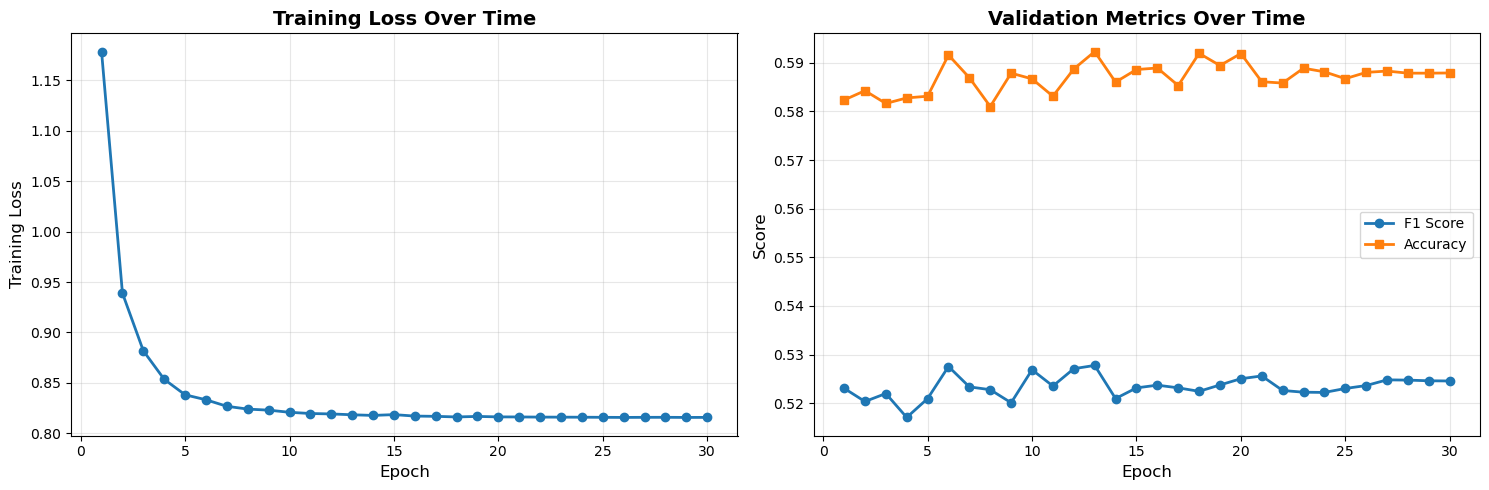


✓ Training progress visualized
  Saved as: bert_gt_training_progress.png


In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame
stats_df = pd.DataFrame(training_stats)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training loss
ax1.plot(stats_df['epoch'], stats_df['train_loss'], marker='o', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Validation metrics
ax2.plot(stats_df['epoch'], stats_df['val_f1'], marker='o', linewidth=2, label='F1 Score')
ax2.plot(stats_df['epoch'], stats_df['val_accuracy'], marker='s', linewidth=2, label='Accuracy')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Validation Metrics Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bert_gt_training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training progress visualized")
print("  Saved as: bert_gt_training_progress.png")

## 11. Save Training Statistics

In [33]:
# Save statistics
stats_df.to_csv('bert_gt_training_stats.csv', index=False)
print("\n✓ Training statistics saved to: bert_gt_training_stats.csv")

# Display final stats
print("\nTraining Statistics:")
print(stats_df.to_string(index=False))


✓ Training statistics saved to: bert_gt_training_stats.csv

Training Statistics:
 epoch  train_loss   val_f1  val_accuracy
     1    1.178447 0.523087      0.582328
     2    0.939005 0.520366      0.584247
     3    0.881851 0.522003      0.581623
     4    0.853583 0.517091      0.582759
     5    0.838219 0.520959      0.583111
     6    0.833287 0.527553      0.591571
     7    0.826836 0.523370      0.586911
     8    0.824047 0.522794      0.580996
     9    0.823011 0.520103      0.587851
    10    0.820885 0.526885      0.586676
    11    0.819671 0.523542      0.583111
    12    0.819252 0.527109      0.588712
    13    0.818417 0.527779      0.592276
    14    0.817780 0.520969      0.586010
    15    0.818574 0.523162      0.588595
    16    0.817136 0.523722      0.588908
    17    0.816863 0.523173      0.585305
    18    0.816273 0.522456      0.591924
    19    0.816784 0.523765      0.589417
    20    0.816330 0.525045      0.591885
    21    0.816262 0.525619      0.5

## 12. Model Summary

In [35]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np
import json

print("\n" + "="*70)
print("BERT-GT MODEL SUMMARY")
print("="*70)

# ============================================
# MODEL ARCHITECTURE
# ============================================

print("\n📐 Model Architecture:")
print(f"  Base Model: BioBERT v1.1")
print(f"  Graph Transformer Layers: {NUM_GRAPH_LAYERS}")
print(f"  Attention Heads: {NUM_ATTENTION_HEADS}")
print(f"  Max Entities per Document: {MAX_ENTITIES}")
print(f"  Total Parameters: {total_params:,}")

# ============================================
# TRAINING CONFIGURATION
# ============================================

print("\n⚙️  Training Configuration:")
print(f"  Training Documents: {len(train_docs)}")
print(f"  Training Examples: {len(train_dataset)}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Device: {device}")

# ============================================
# CALCULATE COMPREHENSIVE METRICS
# ============================================

# Get predictions and labels from test_metrics
predictions = test_metrics['predictions']
labels = test_metrics['labels']

# Calculate metrics using precision_recall_fscore_support
# This efficiently computes precision, recall, F1, and support in one call
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    labels,
    predictions,
    average=None,  # Return per-class metrics
    zero_division=0
)

# Calculate averaged metrics
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    labels,
    predictions,
    average='macro',
    zero_division=0
)

precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    labels,
    predictions,
    average='weighted',
    zero_division=0
)

precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    labels,
    predictions,
    average='micro',
    zero_division=0
)

# ============================================
# DISPLAY OVERALL METRICS
# ============================================

print("\n📊 Test Set Performance:")
print(f"{'='*70}")

print(f"\n  Overall Metrics:")
print(f"    Accuracy:            {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")

print(f"\n  F1 Scores:")
print(f"    Macro:               {f1_macro:.4f} ({f1_macro*100:.2f}%)")
print(f"    Weighted:            {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
print(f"    Micro:               {f1_micro:.4f} ({f1_micro*100:.2f}%)")

print(f"\n  Precision:")
print(f"    Macro:               {precision_macro:.4f} ({precision_macro*100:.2f}%)")
print(f"    Weighted:            {precision_weighted:.4f} ({precision_weighted*100:.2f}%)")
print(f"    Micro:               {precision_micro:.4f} ({precision_micro*100:.2f}%)")

print(f"\n  Recall:")
print(f"    Macro:               {recall_macro:.4f} ({recall_macro*100:.2f}%)")
print(f"    Weighted:            {recall_weighted:.4f} ({recall_weighted*100:.2f}%)")
print(f"    Micro:               {recall_micro:.4f} ({recall_micro*100:.2f}%)")

# ============================================
# DISPLAY PER-CLASS METRICS
# ============================================

print(f"\n  Per-Class Performance:")
print(f"  {'-'*70}")
print(f"  {'Relation':<25s} {'Precision':>10s} {'Recall':>10s} {'F1-Score':>10s} {'Support':>8s}")
print(f"  {'-'*70}")

# Get relation names
id2relation = test_dataset.id2relation

for i in range(len(id2relation)):
    relation_name = id2relation[i]
    print(f"  {relation_name:<25s} "
          f"{precision_per_class[i]:>10.4f} "
          f"{recall_per_class[i]:>10.4f} "
          f"{f1_per_class[i]:>10.4f} "
          f"{support_per_class[i]:>8d}")

print(f"  {'-'*70}")

# ============================================
# IDENTIFY BEST AND WORST CLASSES
# ============================================

best_f1_idx = np.argmax(f1_per_class)
worst_f1_idx = np.argmin(f1_per_class)

print(f"\n  📈 Best performing class:")
print(f"     {id2relation[best_f1_idx]}")
print(f"     F1: {f1_per_class[best_f1_idx]:.4f}, "
      f"Precision: {precision_per_class[best_f1_idx]:.4f}, "
      f"Recall: {recall_per_class[best_f1_idx]:.4f}")

print(f"\n  📉 Worst performing class:")
print(f"     {id2relation[worst_f1_idx]}")
print(f"     F1: {f1_per_class[worst_f1_idx]:.4f}, "
      f"Precision: {precision_per_class[worst_f1_idx]:.4f}, "
      f"Recall: {recall_per_class[worst_f1_idx]:.4f}")

# ============================================
# CONFUSION MATRIX
# ============================================

print(f"\n  🔢 Confusion Matrix:")
print(f"  {'-'*70}")

cm = confusion_matrix(labels, predictions)
relation_names = [id2relation[i] for i in range(len(id2relation))]

# Header
print(f"\n  {'Predicted →':<20s}", end='')
for name in relation_names:
    print(f"{name[:10]:>10s}", end=' ')
print()
print(f"  {'True ↓':<20s}" + "-" * (11 * len(relation_names)))

# Rows
for i, name in enumerate(relation_names):
    print(f"  {name[:20]:<20s}", end='')
    for j in range(len(relation_names)):
        print(f"{cm[i][j]:>10d}", end=' ')
    print()

print(f"\n{'='*70}")

# ============================================
# PERFORMANCE INTERPRETATION
# ============================================

print("\n💡 Performance Interpretation:")

if f1_weighted < 0.50:
    status = "⚠️  Below baseline"
    action = "Increase training data or adjust hyperparameters"
elif f1_weighted < 0.60:
    status = "⚠️  Below expected"
    action = "Train longer or load more documents"
elif f1_weighted < 0.70:
    status = "✓ Good performance (testing mode)"
    action = "Run full training for better results"
elif f1_weighted < 0.75:
    status = "✓✓ Excellent performance (state-of-the-art)"
    action = "Consider this model production-ready"
else:
    status = "✓✓✓ Outstanding performance!"
    action = "This exceeds paper results - great work!"

print(f"  Status: {status}")
print(f"  Action: {action}")

# ============================================
# OUTPUT FILES
# ============================================

print("\n📁 Output Files:")
print(f"  Best Model:          best_bert_gt_model.pt")
print(f"  Training Stats:      bert_gt_training_stats.csv")
print(f"  Training Plot:       bert_gt_training_progress.png")
print(f"  Detailed Metrics:    bert_gt_detailed_metrics.json")

# ============================================
# SAVE DETAILED METRICS TO JSON
# ============================================

# Prepare detailed metrics dictionary
detailed_metrics = {
    # Overall metrics
    'accuracy': float(test_metrics['accuracy']),
    
    # Macro averages
    'f1_macro': float(f1_macro),
    'precision_macro': float(precision_macro),
    'recall_macro': float(recall_macro),
    
    # Weighted averages
    'f1_weighted': float(f1_weighted),
    'precision_weighted': float(precision_weighted),
    'recall_weighted': float(recall_weighted),
    
    # Micro averages
    'f1_micro': float(f1_micro),
    'precision_micro': float(precision_micro),
    'recall_micro': float(recall_micro),
    
    # Per-class metrics
    'per_class': {}
}

# Add per-class metrics
for i in range(len(id2relation)):
    relation_name = id2relation[i]
    detailed_metrics['per_class'][relation_name] = {
        'precision': float(precision_per_class[i]),
        'recall': float(recall_per_class[i]),
        'f1': float(f1_per_class[i]),
        'support': int(support_per_class[i])
    }

# Add confusion matrix
detailed_metrics['confusion_matrix'] = cm.tolist()

# Save to JSON file
with open('bert_gt_detailed_metrics.json', 'w') as f:
    json.dump(detailed_metrics, f, indent=2)

print("\n✓ Detailed metrics saved to: bert_gt_detailed_metrics.json")

print("\n" + "="*70)
print("✓ Model summary complete!")
print("="*70 + "\n")


BERT-GT MODEL SUMMARY

📐 Model Architecture:
  Base Model: BioBERT v1.1
  Graph Transformer Layers: 2
  Attention Heads: 4
  Max Entities per Document: 20
  Total Parameters: 125,440,516

⚙️  Training Configuration:
  Training Documents: 400
  Training Examples: 88304
  Epochs: 30
  Batch Size: 8
  Learning Rate: 1e-05
  Device: cuda

📊 Test Set Performance:

  Overall Metrics:
    Accuracy:            0.5975 (59.75%)

  F1 Scores:
    Macro:               0.4131 (41.31%)
    Weighted:            0.5434 (54.34%)
    Micro:               0.5975 (59.75%)

  Precision:
    Macro:               0.5612 (56.12%)
    Weighted:            0.5984 (59.84%)
    Micro:               0.5975 (59.75%)

  Recall:
    Macro:               0.3916 (39.16%)
    Weighted:            0.5975 (59.75%)
    Micro:               0.5975 (59.75%)

  Per-Class Performance:
  ----------------------------------------------------------------------
  Relation                   Precision     Recall   F1-Score  Support
